In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from astropy.io import ascii

### Useful functions

Define a function to read in catalogue files as pandas dataframes

In [2]:
columns = ['RA', 'Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','ia','field']

In [3]:
def readcat(field=1) -> pd.DataFrame:
    filename = f'./catdata/m{field:03d}p.ascd'
    try:
        catdf = pd.read_csv(filename, header=0, index_col=False, names=columns,delim_whitespace=True)
    except FileNotFoundError:
        print(f"Field {field} file not found.")
    return catdf

Function to convert RA Dec to degrees from a dataframe

In [4]:
def convert_radec(df) -> pd.DataFrame:
    # Convert RA to degrees
    ra_col = []
    for ra in df['RA']:
        hms = [float(t) for t in ra.split(':')]
        deg = 15*(hms[0]+hms[1]/60+hms[2]/3600)
        ra_col.append(deg)
    # Convert dec to degrees
    dec_col = []
    for dec in df['Dec']:
        hms = [float(t) for t in dec.split(':')]
        deg = hms[0]+hms[1]/60+hms[2]/3600
        dec_col.append(deg)
    #Update the dataframe and return
    df['RA'] = ra_col
    df['Dec'] = dec_col
    return df

## Table2.txt
read table2.txt and calculate a dictionary of positions for each field

In [9]:
tab2col = ['yr','mon','d','h','min','s','mjd','RAh','RAm','RAs','DEd','DEm','DEs','ExpID','FieldID','Other','PID','Filter','Exp']
file = './catdata/Table2.txt'
tab2df = pd.read_csv(file, header=0, index_col=False, names=tab2col,delim_whitespace=True)


In [13]:
tab2df = tab2df[['RAh','RAm','RAs','DEd','DEm','DEs','FieldID']]

In [16]:
fields = set(tab2df['FieldID'])

In [34]:
field_positions = {}
for f in fields:
    d = tab2df[tab2df['FieldID']==f].iloc[0] # take a single entry as the RA, Dec values are very similar
    RA = 15*(d[0]+d[1]/60+d[2]/3600)
    Dec = d[3]+d[4]/60+d[5]/3600
    field_positions[f] = (RA,Dec)

## Read in data

In [5]:
CAT = pickle.load(open('./pickle/cat236_257.pk','rb'))

### Code to read new catalogues in

We're reading in 236-257 to span left to right across M31

In [4]:
CAT = {}
cats_to_read = range(213,220) # 236->257 spans directly across M31
                              # 258->279 spans across M31, one row above

In [5]:
%%timeit
for a in cats_to_read:
    CAT[a] = readcat(a)
    #CAT[a] = convert_radec(CAT[a])

9.39 s ± 68.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Get mean position of each field

In [133]:
field_mean_pos = {}
for i in CAT:
    length = len(CAT[i]['RA'])
    # RA values span from 23h to 2h so we centre the values around 0 (converting 23h into a negative value)
    ra_centered = [(a+20)%360-20 for a in CAT[i]['RA']]
    mean_ra = sum(ra_centered)/length
    mean_dec = sum(CAT[i]['Dec'])/length
    field_mean_pos[i] = (mean_ra, mean_dec)

Pickle the dict of df

In [139]:
with open('./pickle/cat213_279.pk','wb') as f:
    pickle.dump(CAT,f)

## Object count

Find an average object count across the range

Count number of each object

In [134]:
count_sat = [len(CAT[c][CAT[c]['ig']==-9]) for c in CAT]
count_star2 = [len(CAT[c][CAT[c]['ig']==-2]) for c in CAT]
count_star1 = [len(CAT[c][CAT[c]['ig']==-1]) for c in CAT]
count_noise = [len(CAT[c][CAT[c]['ig']==0]) for c in CAT]
count_gal1 = [len(CAT[c][CAT[c]['ig']==1]) for c in CAT]
count_gal2 = [len(CAT[c][CAT[c]['ig']==2]) for c in CAT]

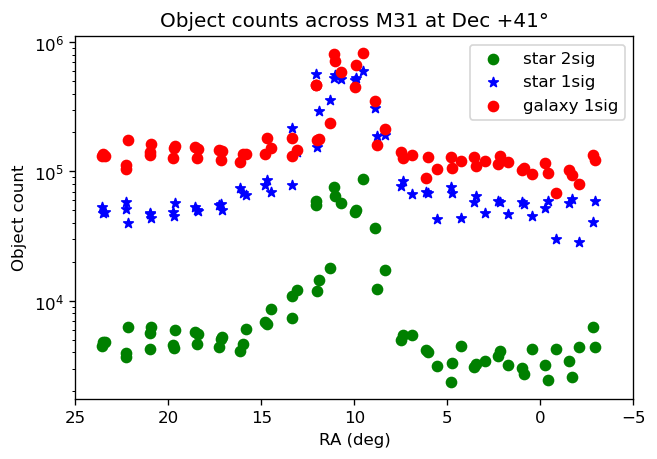

In [135]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.set_dpi(120)

ax1.set_yscale('log')

ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], count_star2, c='g', label='star 2sig')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], count_star1, c='b',marker='*', label='star 1sig')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], count_gal1, c='r', label='galaxy 1sig')
plt.legend(loc='upper right')
plt.xlabel('RA (deg)')
plt.ylabel('Object count')
plt.title('Object counts across M31 at Dec +41°')
plt.xlim(-5,25)
plt.gca().invert_xaxis()

## Colour
Calculate average colour of each class

Colours based on ii **and** ig guesses

In [148]:
colours = {}
#calculate mean g-i colour of each field
for n in CAT:
    col_sat = np.mean(CAT[n]['g'][(CAT[n]['ig']==-9)&(CAT[n]['ii']==-9)] - CAT[n]['i'][(CAT[n]['ig']==-9)&(CAT[n]['ii']==-9)])
    col_2sigstar = np.mean(CAT[n]['g'][(CAT[n]['ig']==-2)&(CAT[n]['ii']==-2)] - CAT[n]['i'][(CAT[n]['ig']==-2)&(CAT[n]['ii']==-2)])
    col_1sigstar = np.mean(CAT[n]['g'][(CAT[n]['ig']==-1)&(CAT[n]['ii']==-1)] - CAT[n]['i'][(CAT[n]['ig']==-1)&(CAT[n]['ii']==-1)])
    col_1siggal  = np.mean(CAT[n]['g'][(CAT[n]['ig']==1)&(CAT[n]['ii']==1)] - CAT[n]['i'][(CAT[n]['ig']==1)&(CAT[n]['ii']==1)])
    col_2siggal = np.mean(CAT[n]['g'][(CAT[n]['ig']==2)&(CAT[n]['ii']==2)] - CAT[n]['i'][(CAT[n]['ig']==2)&(CAT[n]['ii']==2)])
    colours[n] = (col_sat,col_2sigstar,col_1sigstar,col_1siggal, col_2siggal)

Colours based **only** on ig guesses

In [146]:
colours = {}
#calculate mean g-i colour of each field
for n in CAT:
    col_sat = np.mean(CAT[n]['g'][CAT[n]['ig']==-9] - CAT[n]['i'][CAT[n]['ig']==-9])
    col_2sigstar = np.mean(CAT[n]['g'][CAT[n]['ig']==-2] - CAT[n]['i'][CAT[n]['ig']==-2])
    col_1sigstar = np.mean(CAT[n]['g'][CAT[n]['ig']==-1] - CAT[n]['i'][CAT[n]['ig']==-1]) 
    col_1siggal  = np.mean(CAT[n]['g'][CAT[n]['ig']==1] - CAT[n]['i'][CAT[n]['ig']==1])
    col_2siggal = np.mean(CAT[n]['g'][CAT[n]['ig']==2] - CAT[n]['i'][CAT[n]['ig']==2])
    colours[n] = (col_sat,col_2sigstar,col_1sigstar,col_1siggal, col_2siggal)

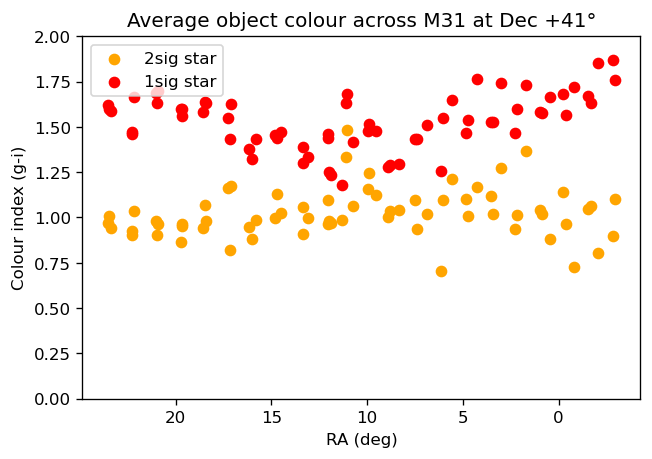

In [149]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.set_dpi(120)

ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][1] for n in colours], c='orange', label='2sig star')
ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][2] for n in colours], c='red', label='1sig star')
#ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][3] for n in colours], c='fuchsia', label='1sig galaxy')
#ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][4] for n in colours], c='violet', label='2sig galaxy')
#ax1.scatter([field_mean_pos[f][0] for f in field_mean_pos], [colours[n][0] for n in colours], c='lightgrey', label='saturated')

plt.legend(loc='upper left')
plt.xlabel('RA (deg)')
plt.ylabel('Colour index (g-i)')
#plt.ylim([-1,2])
plt.title('Average object colour across M31 at Dec +41°')
plt.ylim(0,2)
plt.gca().invert_xaxis()